# Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.applications.mobilenet import MobileNet
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

import glob
import os
import random
import cv2

In [3]:
## Declare Directory
train_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
val_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"
test_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"

classes = ["With Mask", "Without Mask"]

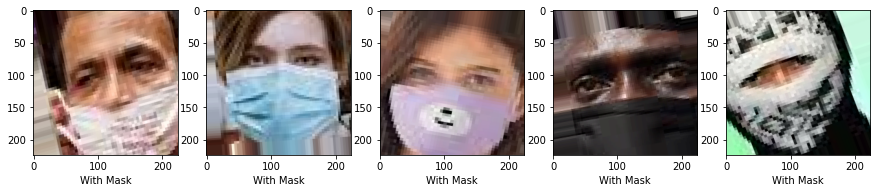

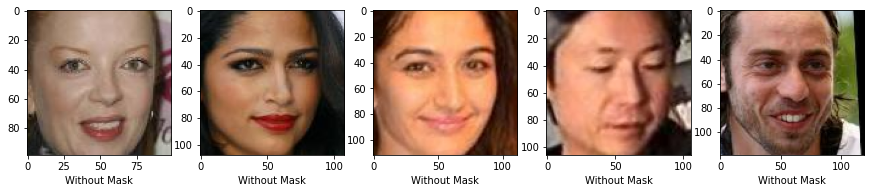

In [4]:
n = 5
## Check Image
plt.figure(figsize=(15, n))
for i in range(n):
    # read image
    sample = random.choice(os.listdir(train_dir + "/WithMask"))
    # print("filename:", sample)
    img_dir = train_dir + "/WithMask/" + sample
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot image
    plt.subplot(1, n, 1+i)
    plt.imshow(img)
    plt.xlabel("With Mask")
plt.show()   

plt.figure(figsize=(15, n))
for i in range(n):
    # read image
    sample = random.choice(os.listdir(train_dir + "/WithoutMask"))
    # print("filename:", sample)
    img_dir = train_dir + "/WithoutMask/" + sample
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot image
    plt.subplot(1, n, 1+i)
    plt.imshow(img)
    plt.xlabel("Without Mask")
plt.show()   

In [5]:
# Dataset loader
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=0.2,
                                #width_shift_range=0.1,
                                #height_shift_range=0.1,
                                shear_range=0.2,
                                #zoom_range=0.09,
                                horizontal_flip=True,
                                vertical_flip=False,
                                #validation_split=0.1
                                )

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Image Generator Config
target_size = (150, 150)
batch_size = 16

# Load Dataset
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True)

val_dataset = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              shuffle=False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Modelling 

In [7]:
base_model = tf.keras.applications.MobileNet(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

17235968/17225924 [==============================] - 1s 0us/step


In [8]:
# Freezing Layer
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model = keras.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(2, activation="softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 32770     
Total params: 3,261,634
Trainable params: 32,770
Non-trainable params: 3,228,864
_________________________________________________________________


In [11]:
## Setting backprop of model (how this model learning)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics ="accuracy")

In [12]:
# Training
EPOCHS = 10
history = model.fit_generator(train_dataset,
                               steps_per_epoch=len(train_dataset)//train_dataset.batch_size,
                               validation_data=val_dataset, 
                               validation_steps=len(val_dataset)//val_dataset.batch_size,
                               epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-24 02:24:53.895031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
39/39 [==============================] - 13s 275ms/step - loss: 0.1231 - accuracy: 0.9744 - val_loss: 4.6441e-07 - val_accuracy: 1.0000
Epoch 2/10
39/39 [==============================] - 9s 239ms/step - loss: 0.0871 - accuracy: 0.9936 - val_loss: 2.5084e-07 - val_accuracy: 1.0000
Epoch 3/10
39/39 [==============================] - 9s 239ms/step - loss: 0.1413 - accuracy: 0.9856 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
39/39 [==============================] - 9s 234ms/step - loss: 0.0646 - accuracy: 0.9872 - val_loss: 4.6577e-04 - val_accuracy: 1.0000
Epoch 5/10
39/39 [==============================] - 9s 232ms/step - loss: 0.2475 - accuracy: 0.9888 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
39/39 [==============================] - 9s 233ms/step - loss: 0.0833 - accuracy: 0.9968 - val_loss: 9.1392e-07 - val_accuracy: 1.0000
Epoch 7/10
39/39 [==============================] - 9s 226ms/step - loss: 0.1280 - accuracy: 0.9872 - val_loss: 1.6953e-04 

# Review Model

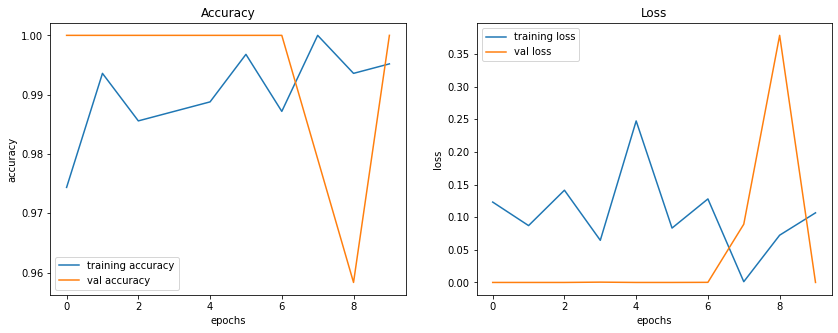

In [13]:
## Review Our Model
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,5))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [14]:
# Load Test Dataset
test_dataset = val_datagen.flow_from_directory(test_dir,
                                            target_size=target_size,
                                            batch_size=1,
                                            class_mode=None,
                                            shuffle=False)

Found 992 images belonging to 2 classes.


In [15]:
probabilities = model.predict_generator(test_dataset)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
y_pred = probabilities.argmax(axis=-1)
y_test = test_dataset.classes

In [17]:
print("Accuracy Score of Model:", accuracy_score(y_pred,y_test))

Accuracy Score of Model: 0.9879032258064516


In [18]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

   With Mask       0.98      1.00      0.99       483
Without Mask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



# Testing model

In [19]:
def preprocessing_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    return img

../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/Augmented_141_8092740.png


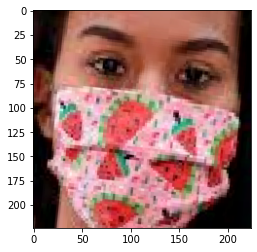

In [20]:
random_test_img = random.choice(glob.glob(test_dir+"/*/*"))
print(random_test_img)
img_test = cv2.imread(random_test_img)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)
plt.show()

In [21]:
img_test = preprocessing_img(img_test)
result = model.predict(img_test)
score = np.max(result)
predicted_class = classes[np.argmax(result)]
print(predicted_class)
print("Confident: ", score)

With Mask
Confident:  1.0


In [ ]:
model.save("face-masked-detection.h5")